# EDA

In [20]:
import numpy as np
import pandas as pd

## 1. Loading Data

In [21]:
columns = [
    "C", "Si", "Mn", "S", "P", "Ni", "Cr", "Mo", "V", "Cu", "Co", "W",
    "O", "Ti", "N", "Al", "B", "Nb", "Sn", "As", "Sb",
    "Current", "Voltage", "AC_DC", "ElectrodePolarity", "HeatInput",
    "InterpassTemp", "WeldType", "PWHT_Temp", "PWHT_Time",
    "YieldStrength", "UTS", "Elongation", "ReductionArea",
    "CharpyTemp", "CharpyImpact", "Hardness", "FATT50", "PrimaryFerrite",
    "Ferrite2ndPhase", "AcicularFerrite", "Martensite", "FerriteCarbide",
    "WeldID"
]

In [22]:
df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')
df.head()

/var/folders/5l/rft89vf91_sc94km3w2pwq400000gn/T/ipykernel_75902/3652121480.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')


,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,CharpyTemp,CharpyImpact,Hardness,FATT50,PrimaryFerrite,Ferrite2ndPhase,AcicularFerrite,Martensite,FerriteCarbide,WeldID
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch


### Dataset analysis

#### What percent of each column is null?

In [23]:
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage.sort_values(ascending=False).round(2)
pd.DataFrame({'Missing elements percentage': missing_percentage})

,Missing elements percentage
FATT50,98.12
W,95.46
FerriteCarbide,94.61
Martensite,94.61
Ferrite2ndPhase,94.55
AcicularFerrite,94.55
PrimaryFerrite,94.07
Co,92.19
Hardness,91.65
As,85.84


## 2. Preprocessing
### Handling outliers
To find outliers, we remove them using the IQR rule:  
If value $< Q1 - 1.5 \times IQR$ or value $> Q3 + 1.5 \times IQR$ :  
    &nbsp;&nbsp;&nbsp;&nbsp;replace it with NaN (because we'll handle missing values next).

In [24]:
# Remove outliers per numeric column using the IQR rule and replace them with NaN
# Exclude non-numeric columns such as 'WeldID' if present
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'WeldID' in numeric_cols:
    numeric_cols.remove('WeldID')
outlier_counts = {}
for col in numeric_cols:
    # compute Q1, Q3 and IQR, skipping columns with all-NaN
    series = df[col].dropna()
    if series.empty:
        outlier_counts[col] = 0
        continue
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or np.isnan(iqr):
        # no spread; skip replacing to avoid removing valid identical values
        outlier_counts[col] = 0
        continue
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    # boolean mask of outliers
    mask = (df[col] < lower) | (df[col] > upper)
    # count how many True (excluding NaNs)
    count = int(mask.sum(skipna=True)) if hasattr(mask, 'sum') else int(mask.sum())
    outlier_counts[col] = count
    # replace outliers with NaN in the original df
    df.loc[mask, col] = np.nan

In [25]:
# Print number of rows in the dataset
print(f"Number of rows: {len(df)}")
# show counts as DataFrame sorted descending
outlier_report = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outliers_replaced']).sort_values('outliers_replaced', ascending=False)
outlier_report

Number of rows: 1652


,outliers_replaced
Current,310
HeatInput,161
O,156
Si,153
Ni,126
Cr,120
Voltage,83
P,76
C,63
CharpyImpact,35


/var/folders/5l/rft89vf91_sc94km3w2pwq400000gn/T/ipykernel_75902/1693226008.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')


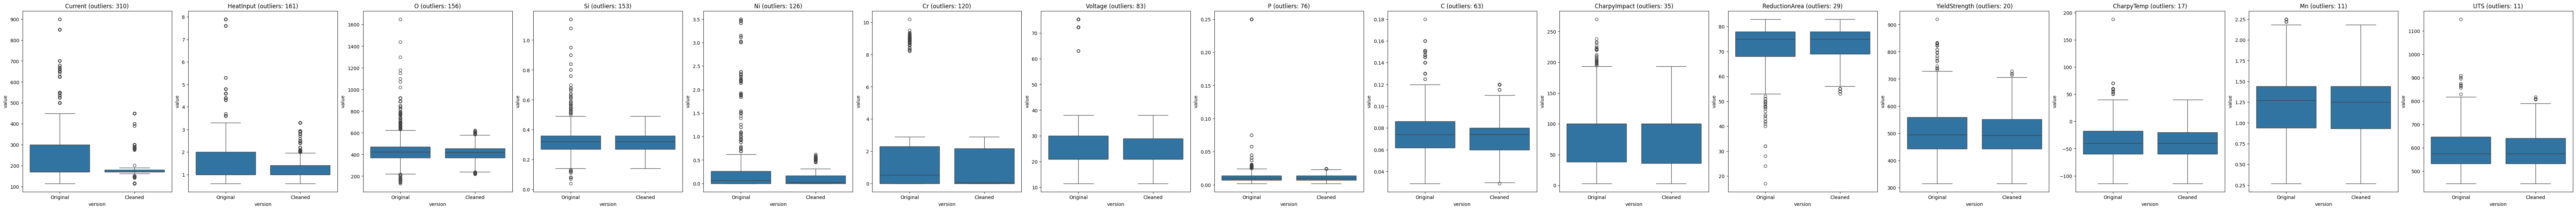

In [ ]:
# Visualize pre/post distributions for columns with many outliers
# This cell reloads the original data file, identifies top columns with outliers from outlier_report,
# and plots side-by-side boxplots comparing original vs cleaned data.
import matplotlib.pyplot as plt
import seaborn as sns
# reload original data to preserve pre-clean values (assumes same path and column names variable exists)
df_orig = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')
# Ensure outlier_report exists; if not, recompute using same logic as cleaning cell
if 'outlier_report' not in globals():
    numeric_cols = df_orig.select_dtypes(include=[np.number]).columns.tolist()
    if 'WeldID' in numeric_cols:
        numeric_cols.remove('WeldID')
    outlier_counts = {}
    for col in numeric_cols:
        series = df_orig[col].dropna()
        if series.empty:
            outlier_counts[col] = 0
            continue
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0 or np.isnan(iqr):
            outlier_counts[col] = 0
            continue
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = (df_orig[col] < lower) | (df_orig[col] > upper)
        outlier_counts[col] = int(mask.sum(skipna=True))
    outlier_report = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outliers_replaced']).sort_values('outliers_replaced', ascending=False)
# select top columns with most outliers (limit to 5)
top_cols = outlier_report[outlier_report['outliers_replaced']>0].head(15).index.tolist()
if not top_cols:
    print('No columns with outliers found to visualize.')
else:
    # prepare cleaned df (should already be modified in the notebook as df), but recompute if not present
    if 'df' not in globals():
        df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')
    # plot side-by-side boxplots for each column
    n = len(top_cols)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5*n, 6), constrained_layout=True)
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, top_cols):
        # combine original and cleaned for plotting
        plot_df = pd.DataFrame({ 'Original': df_orig[col], 'Cleaned': df[col] })
        # melt for seaborn
        plot_melt = plot_df.melt(var_name='version', value_name='value')
        sns.boxplot(x='version', y='value', data=plot_melt, ax=ax)
        ax.set_title(f"{col} (outliers: {outlier_report.loc[col,'outliers_replaced']})")
    plt.show()